# Robust Shadow Tomography

Robust shadows, as introduced in the papers [Chen et al., PRX Quantum 2021](https://doi.org/10.1103/PRXQuantum.2.030348) and [Koh et al., Quantum 2022](https://quantum-journal.org/papers/q-2022-08-16-776/), allow to faithfully estimate physical properties despite the presence of measurement errors. 

It involves two steps:

1. Calibration: This relies on the assumption that certain simple states, e.g. the fully-polarized all 0 state, can be prepared with very high fidelity. We then use randomized measurements to estimate this fidelity. Due to measurement errors in the randomized measurement, we estimate a smaller values. This, we can use to calibrate the relevant noise parameters. 
2. Experiment: We perform randomized measurement on the actual target state of interest. Under the assumption that the measurement error is the same as in the calibration experiment, we use **robust classical shadows** to mitigate the effect of measurement error and obtain a robust (measurement-error mitigated) estimation of the properties of interest.

In this tutorial, we will use the efficient calibration method based on the experimental demonstration of robust classical shadows [Vitale et al., PRX Quantum 2024](https://doi.org/10.1103/PRXQuantum.5.030338). This calibration is based on on common randomized measurements [Vermersch et al., PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352). 

In [ ]:
using RandomMeas

The calibration of robust classical shadows is based on the preparation of a state $\psi_0$ with very high fidelity. We then perform noisy randomized measurements to learn about the averaged (aka ``twirled'') effect of the noise. 

In [2]:
N = 6
ξ = siteinds("Qubit", N)
states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states);

Under the assumption of a gate independent noise described by a channel $\Lambda=\bigotimes \Lambda_i$, the calibration step will attempt to measure the numbers $G=\frac{1}{2}\sum_{s=0,1}\bra{s}\Lambda_i(\ket{s}\bra{s})\ket{s}\le 1$.

In this example, we simulate numerically this calibration process using  local depolarization channels $\Lambda_i$ with probability $p_i$


In [18]:
p = [max(0, min(0.1 + 0.02 * randn(), 1)) for i in 1:N] #vector of probabilities for each qubit
G = 1 .-p/2; #exact values of G (which we will measure via the calibration stage)

ρ0n = apply_depo_channel(ψ0,p); #apply the depolarizing channel to the initial state

$G$ can be efficiently measured using the randomized measurement estimator provided in [Vitale et al, arxiv:2307.16882](http://arxiv.org/abs/2307.16882)
$$G_e[i]=E_u[\sum_s 3(P_i(s)-\tilde P_i(s)) \tilde P_i(s)+1]$$
where $P_i$ is the measured Born probability, while $\tilde P_i$ is the one what would get in the absence of noise.

In [19]:
# ------------------------------------------------------------------------------
# Simulation Parameters
# ------------------------------------------------------------------------------

NU = 500       # Number of random unitaries to sample for the simulation.
NM = 100       # Number of projective measurements per unitary setting.

# ------------------------------------------------------------------------------
# Initialization
# ------------------------------------------------------------------------------

# G_e stores the estimated G values (one for each subsystem or qubit).
G_e = zeros(Float64, N)

# ------------------------------------------------------------------------------
# Generating Measurement Settings and Data

@showprogress dt=1 for i in 1:N
    reduced_measurement_group = reduce_to_subsystem(measurement_group, [i])
    
    for r in 1:NU
            # Compute the measured Born probabilities for qubit i using the actual measurement data
        data = reduced_measurement_group.measurements[r]
        P_measured = MeasurementProbability(data).measurement_probability
            # Compute the expected Born probabilities for qubit i from the ideal (noise-free) state ψ0.
        P_expected = MeasurementProbability(reduce_to_subsystem(ψ0,collect(i:i)), data.measurement_setting).measurement_probability
        cross_corr = (P_measured * P_expected)[]
        self_corr = (P_expected * P_expected)[]
    
        # Estimate the G value for qubit i using the formula:
        #     G_e[i] = 3 * (mean(cross_corr_first - self_corr_first)) + 1,

        G_e[i] += 3 * (cross_corr-self_corr)/NU + 1/NU
    end
    
end# ------------------------------------------------------------------------------
measurement_group = MeasurementGroup(ρ0n,NU,NM;mode="dense");


# ------------------------------------------------------------------------------
# Estimation Loop: Estimate G_e for Each Qubit
# ------------------------------------------------------------------------------

println("G values: ",G)
println("Estimated G values: ", G_e)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


G values: [0.9747032071590439, 0.9381179336252883, 0.9493829156255236, 0.9451439955169284, 0.9563118595957711, 0.9646323328005176]
Estimated G values: [0.9696301516714239, 0.9317987790050123, 0.9461992188926961, 0.9496080464633299, 0.945774355625648, 0.9656453838064645]


We can now check that the measured calibration vector is close to the exact one (or increase the number of measurements to reduce statitical errors)

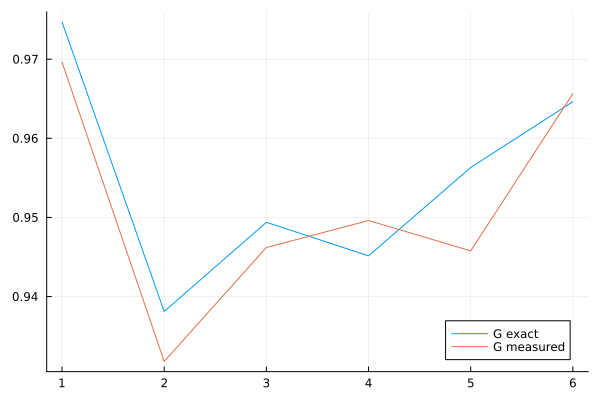

In [20]:
using Plots
plot(G,label="G exact")
plot!(G_e,label="G measured")

This ends the calibration stage. We are now ready to robustly estimate physical properties for an unknown quantum state.

We first simulate the ideal circuit and add at the end *the same* local depolarizing noise as before to simulate measurement noise.

In [21]:
depth = 2
circuit = random_circuit(ξ,depth)
ψ = apply(circuit,ψ0);
ρn = apply_depo_channel(ψ,p); #as for the calibration, the state is affected by local depolarization during the measurement


In [22]:
# ------------------------------------------------------------------------------
# Simulation Parameters
# ------------------------------------------------------------------------------

NU = 2000       # Number of random unitaries to sample for the simulation.
NM = 1000       # Number of projective measurements per unitary setting.

# ------------------------------------------------------------------------------
# Generating Measurement Settings and Data
# ------------------------------------------------------------------------------
measurement_group = MeasurementGroup(ρn,NU,NM;mode="dense");


# Measuring Subsystem Purities

In this section, we evaluate the purities of various subsystems, quantified by the expression

$$
\mathrm{tr}(\rho_A^2),
$$

using two different approaches based on classical shadows:

1. **Non-Robust Shadows:**  
   This estimator directly computes the purity from the measurement data.

2. **Robust Shadows:**  
   This enhanced estimator incorporates calibration information via the vector $ G_e $. The vector $ G_e $ has obtained during the calibration procedure.

By comparing the results from these two estimators, we can assess the benefits of using robust shadows in practical scenarios.

In [27]:
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_e = zeros(Float64,N) #purity with non-robust shadows
purity_robust = zeros(Float64,N) #purity with robust shadows

@showprogress dt=1 for NA in 1:N

    reduced_group = reduce_to_subsystem(measurement_group, collect(1:NA))
    standard_shadows = get_dense_shadows(reduced_group;number_of_ru_batches=25)
    robust_shadows = get_dense_shadows(reduced_group;number_of_ru_batches=25,G=G_e[1:NA])

    purity[NA] = get_trace_moment(ψ,2,collect(1:NA))
    purity_e[NA] = get_trace_moment(standard_shadows,2)
    purity_robust[NA] = get_trace_moment(robust_shadows,2)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


We observe that the purity is correctly measured with robust shadows, while non-robust shadows underestimate the value (the intuition is that measurement noise makes the state look effectively more mixed)

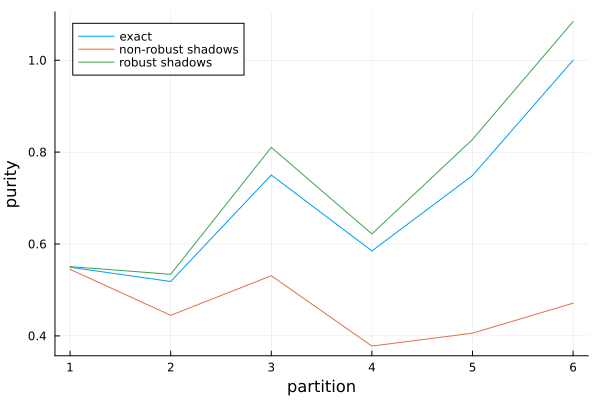

In [28]:
using Plots
plot(1:N,purity,label="exact")
plot!(1:N,purity_e,label="non-robust shadows")
plot!(1:N,purity_robust,label="robust shadows")
xlabel!("partition")
ylabel!("purity")